## Chapter 19 -- Constrained nonlinear least-squares

Modified by kmp 2022

Sources:

https://web.stanford.edu/~boyd/vmls/

https://github.com/vbartle/VMLS-Companions

Based on "Boyd and Vandenberghe, 2021, Introduction to Applied Linear Algebra: Vectors, Matrices, and Least Squares - Julia Language Companion" https://web.stanford.edu/~boyd/vmls/vmls-julia-companion.pdf


In [1]:
using LinearAlgebra
using VMLS

### 19.2 Penalty algorithm

Let us implement the penalty algorithm (algorithm [19.1](https://web.stanford.edu/~boyd/vmls/vmls.pdf#algorithmctr.19.1) in VMLS).

In [2]:
function penalty_method(f, Df, g, Dg, x1, lambda1; kmax = 100,
        feas_tol = 1e-4, oc_tol = 1e-4)
    x = x1
    mu = 1.0
    feas_res = [norm(g(x))]
    oc_res = [norm(2*Df(x)'*f(x) + 2*mu*Dg(x)'*g(x))]
    lm_iters = zeros(Int64,0,1)

    for k=1:kmax
        F(x) = [f(x); sqrt(mu)*g(x)]
        DF(x) = [Df(x); sqrt(mu)*Dg(x)]
        x, hist = levenberg_marquardt(F,DF,x,lambda1,tol=oc_tol)
        feas_res = [feas_res; norm(g(x))]
        oc_res = [oc_res; hist["residuals"][end]]
        lm_iters = [lm_iters; length(hist["residuals"])]
        
        if norm(g(x)) < feas_tol
            break
        end
        mu = 2*mu
    end

    return x, Dict([ ("lm_iterations", lm_iters),
            ("feas_res", feas_res), ("oc_res", oc_res) ])
end

penalty_method (generic function with 1 method)

On line $11$ we call the function **`levenberg_marquardt`** of the previous chapter to minimize $‖F(x)‖^2$ where

$$
F (x) =
\begin{bmatrix}
f(x)\\
\sqrt{µ}g(x)
\end{bmatrix}
.
$$

We evaluate two residuals. The **`feasibility residual`** $‖g(x(k))‖$ is the error in the constraint $g(x) = 0$. The **`optimality condition residual`** is defined as

$$
‖2Df(x^{(k)})^T f(x^{(k)}) + 2Dg(x^{(k)})^T z^{(k)}‖
$$

where $z(k) = 2µ(k−1)g(x(k))$ (and we take $µ(0) = µ(1)$). 

On line $13$, we obtain the optimality condition residual as the last residual in the Levenberg–Marquardt method. 

On line $20$ we return the final $x$, and a dictionary containing the two sequences of residuals and the number of iterations used in each call to the Levenberg–Marquardt algorithm.

**Example.** We apply the method to a problem with two variables

$$
f(x_1, x_2) =
\begin{bmatrix}
x_1 + exp(−x_2) \\
x^2_1 + 2x_2 + 1
\end{bmatrix}
 , 
g(x_1, x_2) = x^2_1 + x^3_1 + x_2 + x^2_2.
$$


In [3]:
f(x) = [ x[1] + exp(-x[2]), x[1]^2 + 2*x[2] + 1 ]

Df(x) = [ 1.0 -exp(-x[2]); 2*x[1] 2 ]

g(x) = [ x[1] + x[1]^3 + x[2] + x[2]^2 ]

Dg(x) = [ 1 + 3*x[1]^2 1 + 2*x[2] ]

x, hist = penalty_method(f, Df, g, Dg, [0.5, -0.5], 1.0)

x

2-element Vector{Float64}:
 -3.3349551411345114e-5
 -2.7682497161012516e-5

The following lines create a staircase plot with the residuals versus the cumulative number of Levenberg–Marquardt iterations as in VMLS figure [19.4](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.19.4). The result is in figure [19.1](#fig1).

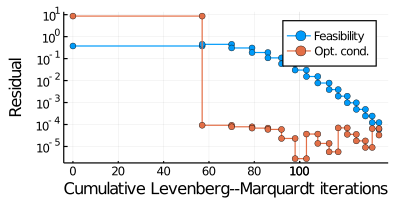

In [4]:
using Plots
cum_lm_iters = cumsum(hist["lm_iterations"], dims=1)

itr = vcat([0], [[i; i] for i in cum_lm_iters]...)

feas_res = vcat([
        [r;r] for r in hist["feas_res"][1:end-1]]...,
    hist["feas_res"][end])

oc_res = vcat([[r;r] for r in hist["oc_res"][1:end-1]]...,
    hist["oc_res"][end])

plot(itr, feas_res, shape=:circle, label = "Feasibility", size=[400,200])
plot!(itr, oc_res, shape=:circle, label = "Opt. cond.")
plot!(yscale = :log10,
    xlabel = "Cumulative Levenberg--Marquardt iterations",
    ylabel = "Residual")

**Figure 19.1** <a ind="#fig1"></a> Feasibility and optimality condition errors versus the cumulative number of Levenberg–Marquardt iterations in the penalty algorithm.

### 19.3 Augmented Lagrangian algorithm

In [5]:
function aug_lag_method(f, Df, g, Dg, x1, lambda1; kmax = 100,
        feas_tol = 1e-4, oc_tol = 1e-4)

    x = x1
    z = zeros(length(g(x)))
    mu = 1.0
    feas_res = [norm(g(x))]
    oc_res = [norm(2*Df(x)'*f(x) + 2*mu*Dg(x)'*z)]
    lm_iters = zeros(Int64,0,1)

    for k=1:kmax
        F(x) = [f(x); sqrt(mu)*(g(x) + z/(2*mu))]
        DF(x) = [Df(x); sqrt(mu)*Dg(x)]
        x, hist = levenberg_marquardt(F, DF, x, lambda1, tol=oc_tol)
        z = z + 2*mu*g(x)
        feas_res = [feas_res; norm(g(x))]
        oc_res = [oc_res; hist["residuals"][end]]
        lm_iters = [lm_iters; length(hist["residuals"])]

        if norm(g(x)) < feas_tol
            break
        end
        mu = (norm(g(x)) < 0.25*feas_res[end-1]) ? mu : 2*mu
    end
    
    return x, z, Dict([ ("lm_iterations", lm_iters),
            ("feas_res", feas_res), ("oc_res", oc_res)])
end

aug_lag_method (generic function with 1 method)

Here the call to the Levenberg–Marquardt algorithm on line $12$ is to minimize
$‖F (x)‖2$ where

$$
F (x) =
\begin{bmatrix}
f(x)\\
\sqrt{µ^{(k)}}(g(x) + \frac{z^{(k)}}{2µ^{(k)}}
\end{bmatrix}
.
$$

We again record the feasibility residuals $‖g(x^{(k)}‖$ and the optimality conditions
residuals

$$
‖2Df(x^{(k)})^T f(x^{(k)}) + 2Dg(x^{(k)})^T z^{(k)}‖,
$$

and return them in a dictionary.

**Example.** We continue the small example.

In [6]:
x, z, hist = aug_lag_method(f, Df, g, Dg, [0.5, -0.5], 1.0)
x

2-element Vector{Float64}:
 -1.864661485588675e-5
 -1.500856782026583e-5

In [7]:
z


1-element Vector{Float64}:
 -1.999958127349911

The following code shows the convergence as in VMLS figure [19.4](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.19.4). The plot is
given in figure [19.2](#fig2).

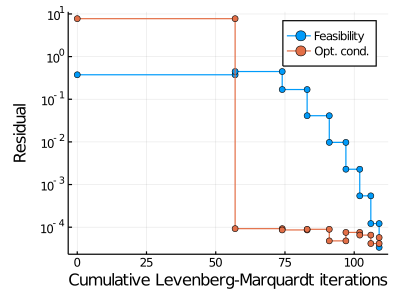

In [9]:
using Plots

cum_lm_iters = cumsum(hist["lm_iterations"],dims=1)

itr = vcat([0], [[i; i] for i in cum_lm_iters]...)

feas_res = vcat([
        [r;r] for r in hist["feas_res"][1:end-1]]...,hist["feas_res"][end])

oc_res = vcat([
        [r;r] for r in hist["oc_res"][1:end-1]]...,
    hist["oc_res"][end])

plot(itr, feas_res, shape=:circle, label = "Feasibility", size=[400,300])
plot!(itr, oc_res, shape=:circle, label = "Opt. cond.")
plot!(yscale = :log10,
    xlabel = "Cumulative Levenberg-Marquardt iterations",
    ylabel = "Residual")

**Figure 19.2** Feasibility and optimality condition errors versus the cumulative number of Levenberg–Marquardt iterations in the augmented Lagrangian algorithm.